In [219]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from IPython.display import display
from sklearn.metrics import auc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 


In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [7]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [8]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [9]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

In [10]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

Setting Up Validation Framework

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(4225, 1409, 1409)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [15]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

EDA

In [16]:
df_full_train = df_full_train.reset_index(drop=True)

In [17]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [18]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

np.float64(0.27)

In [19]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [20]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [21]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [22]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

Churn Rate

In [23]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

np.float64(0.27682403433476394)

In [24]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [25]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

np.float64(0.20503330866025166)

In [26]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

np.float64(0.3298090040927694)

In [27]:
df_group = df_full_train.groupby('gender').churn.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_churn_rate
df_group['risk'] = df_group['mean'] / global_churn_rate
df_group

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


In [28]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


Mutual Information

In [29]:
from sklearn.metrics import mutual_info_score

In [30]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [31]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [32]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

0.009967689095399745

In [33]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [34]:
df_full_train[categorical].apply(mutual_info_churn_score).sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

Correlation

In [35]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

One-Hot Encoding

In [36]:
from sklearn.feature_extraction import DictVectorizer

In [37]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [38]:
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [39]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [40]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')   

In [41]:
X_val = dv.transform(val_dicts)

Logic Regression

In [42]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [43]:
z = np.linspace(-7, 7, 51)

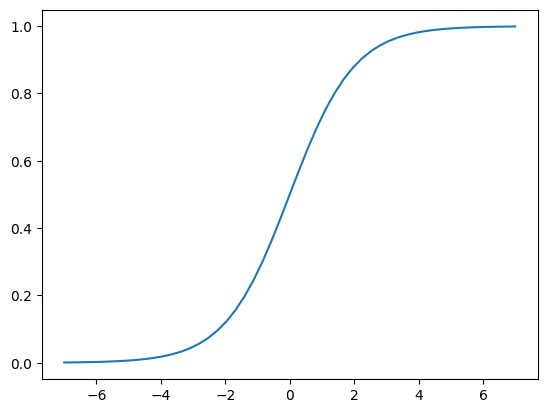

In [44]:
plt.plot(z, sigmoid(z))

In [45]:
def logistic_regression(xi):
    score = w0

    for j in range(len(w)):
        score = score + xi[j] + w[j]

    result = sigmoid(score)
    return result

Logistic Regression with Scikit-Learn

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\solod\ml-zoomcamp-hw\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [48]:
y_pred = model.predict_proba(X_val)[:, 1]

In [49]:
churn_decision = (y_pred >= 0.5)

In [50]:
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 312, dtype: object

In [51]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [52]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [53]:
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.008968,0,0,True
1,0.204542,0,0,True
2,0.212152,0,0,True
3,0.543024,1,1,True
4,0.213658,0,0,True
...,...,...,...,...
1404,0.313711,0,0,True
1405,0.039280,0,1,False
1406,0.136322,0,0,True
1407,0.799954,1,1,True


In [54]:
df_pred.correct.mean()

np.float64(0.8026969481902059)

In [55]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.476),
 'contract=one_year': np.float64(-0.175),
 'contract=two_year': np.float64(-0.408),
 'dependents=no': np.float64(-0.03),
 'dependents=yes': np.float64(-0.078),
 'deviceprotection=no': np.float64(0.063),
 'deviceprotection=no_internet_service': np.float64(-0.089),
 'deviceprotection=yes': np.float64(-0.081),
 'gender=female': np.float64(-0.034),
 'gender=male': np.float64(-0.073),
 'internetservice=dsl': np.float64(-0.336),
 'internetservice=fiber_optic': np.float64(0.317),
 'internetservice=no': np.float64(-0.089),
 'monthlycharges': np.float64(0.004),
 'multiplelines=no': np.float64(-0.258),
 'multiplelines=no_phone_service': np.float64(0.142),
 'multiplelines=yes': np.float64(0.009),
 'onlinebackup=no': np.float64(0.063),
 'onlinebackup=no_internet_service': np.float64(-0.089),
 'onlinebackup=yes': np.float64(-0.081),
 'onlinesecurity=no': np.float64(0.266),
 'onlinesecurity=no_internet_service': np.float64(-0.089),
 'onlinesecurity=yes'

In [56]:
small = ['contract', 'tenure', 'monthlycharges']

In [57]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [58]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [59]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [60]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [61]:
X_train_small = dv_small.transform(dicts_train_small)

In [62]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [63]:
w0 = model_small.intercept_[0]
w0

np.float64(-2.477957596026966)

In [64]:
w = model_small.coef_[0]
w

array([ 0.9711394 , -0.02379507, -0.94828863,  0.02748534, -0.03619005])

In [65]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

Using The Model

In [66]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [67]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [68]:
y_full_train = df_full_train.churn.values

In [69]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

c:\Users\solod\ml-zoomcamp-hw\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [70]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [71]:
y_predict = model.predict_proba(X_test)[:, 1]

In [72]:
churn_dec = (y_predict >= 0.5)

In [73]:
(churn_dec == y_test).mean()

np.float64(0.8140525195173882)

In [74]:
customer = dicts_test[10]
customer

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

In [75]:
X_small = dv.transform([customer])

In [76]:
model.predict_proba(X_small)[0, 1]

np.float64(0.4965472633435293)

In [77]:
y_test[10]

np.int64(0)

Evaluation Metrics

In [78]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [79]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [80]:
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print('%.2f %.3f' % (t, score))

0.00 0.274
0.05 0.510
0.10 0.592
0.15 0.667
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.794
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


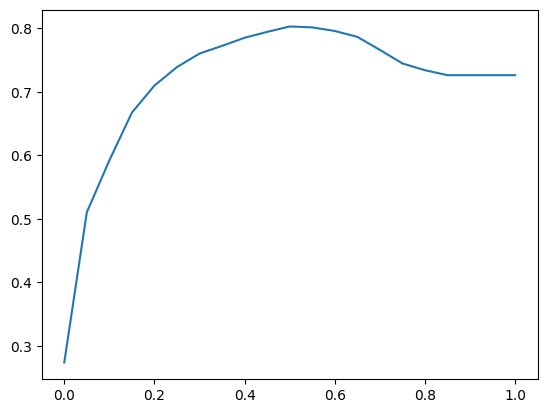

In [81]:
plt.plot(thresholds, scores)

Confusion Matrix

In [149]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [150]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [151]:
confusion_matrix = np.array([[tn, fp],
                             [fn, tp]])
confusion_matrix

array([[921, 102],
       [176, 210]])

Precision and Recall

In [152]:
precision = tp / (tp + fp)
print(f'Precision: {precision}')

recall = tp / (tp + fn)
print(f'Recall: {recall}')

Precision: 0.6730769230769231
Recall: 0.5440414507772021


ROC Curve

In [153]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [154]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [155]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, tn, fp, fn))



In [156]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,468,555,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,921,102,176
60,0.6,151,970,53,235
70,0.7,76,1003,20,310
80,0.8,13,1021,2,373
90,0.9,0,1023,0,386


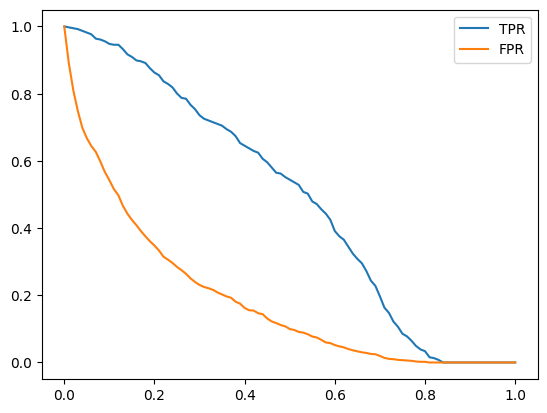

In [157]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

Random Model

In [158]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [159]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [160]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, tn, fp, fn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [161]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [162]:
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


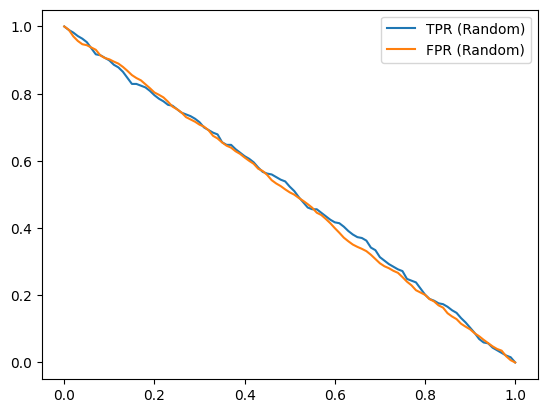

In [163]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR (Random)')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR (Random)')
plt.legend()

Ideal Model

In [164]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [165]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [166]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [167]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [168]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

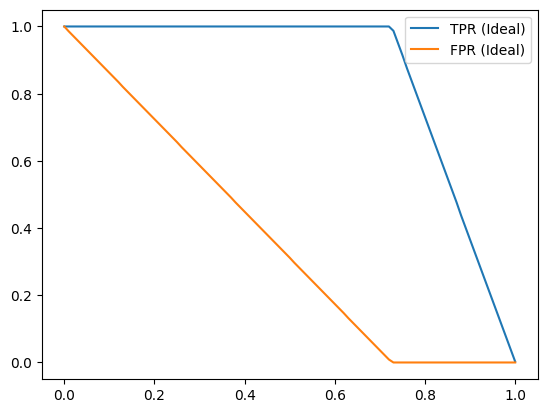

In [169]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR (Ideal)')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR (Ideal)')
plt.legend()

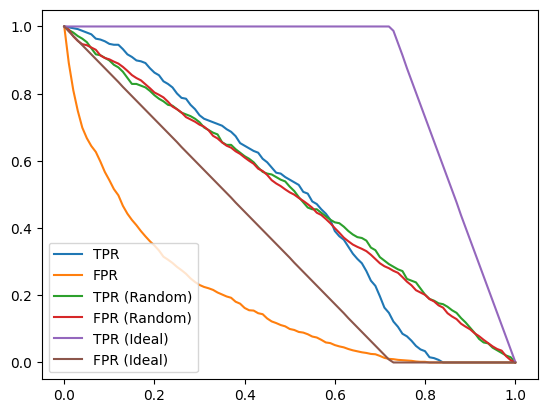

In [170]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

plt.plot(df_rand.threshold, df_rand.tpr, label='TPR (Random)')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR (Random)')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR (Ideal)')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR (Ideal)')
plt.legend()

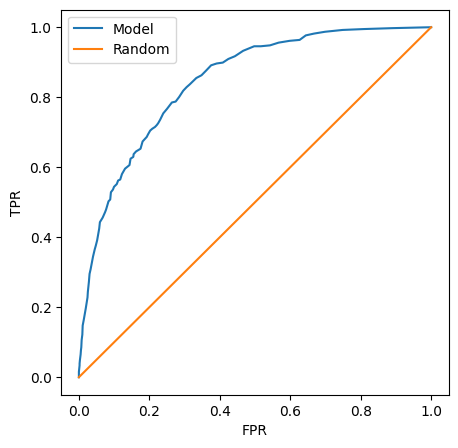

In [171]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [172]:
# Using sklearn to compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

ROC AUC 

In [175]:
auc(fpr, tpr)

0.8438150517374987

In [176]:
auc(df_scores.fpr, df_scores.tpr)

0.843869498933848

In [177]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [179]:
roc_auc_score(y_val, y_pred)

0.8438150517374987

In [180]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [189]:
# Manual and Numpy Implementations of AUC
n = 100000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

print(f'Manual implementation of AUC: {success / n}')

nn = 50000
np.random.seed(1)
pos_i = np.random.randint(0, len(pos), size=nn)
neg_i = np.random.randint(0, len(neg), size=nn)
print(f'NumPy implementation of AUC: {(pos[pos_i] > neg[neg_i]).mean()}')

Manual implementation of AUC: 0.84264
NumPy implementation of AUC: 0.8464


Cross-Validation

In [221]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [222]:
dv, model = train(df_train, y_train, C=0.001)

In [223]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [224]:
y_pred = predict(df_val, dv, model)

In [225]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        #del df_train['churn']
        #del df_val['churn']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    
    print('C=%.3f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

In [228]:
print('C=%.3f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=10.000 0.842 +- 0.007


In [ ]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
        
score = roc_auc_score(y_test, y_pred)

In [233]:
score

0.8583327916626041